# Scenario
- This experiment's goal is to investigate in machine learning model performance on how good they are able to identify people who are smoking. Furthermore, it is also going to be cleared which factor(s) will have more effect on model's prediction.
- In medical industry, such system can be helpful to identify patients who are smoking. This will help doctors to have a broader knowledge and view to treat with the patient.

# Plan
- Reading data and understanding data
- Implementation of preprocessing steps
    * Dropping unnecessary columns
    * Separating features from the column that indicates person status
    * Encoding variables that contain categorical values (such as M(Male) or F(Female))
    * Using labeling method for the target column
    * Splitting data into train and test sets
        * Shuffling, stratifying, test_size = 20%
    * Scaling data
        * MinMaxScalar
- Training models
    * Selecting and training 3 models
    * Hyper-parameter tuning
- Evaluation of models
- Feature importance 
- Conclusion

# Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

Functions

In [2]:
# Function to print line of stars
def print_stars(n=30):
    print('*' * n)

In [3]:
# Function to plot distribution of classes
def plot_distribution(data, title='Distribution of classes in the dataset', type="percent"):
    if type ==  'percent':
        # Function to calculate the distribution of classes in dataset
        def calculate_distr(value, data):
            return data.value_counts()[value]/(data.value_counts()[0] + data.value_counts()[1]) * 100

        ax = sns.barplot(pd.DataFrame({'0': [calculate_distr(0, data)], '1': [calculate_distr(1, data)]}))
        ax.bar_label(ax.containers[0], label_type='edge')
        ax.set(title=title)

    elif type == 'actual':
        ax = sns.barplot(pd.DataFrame({'0': [data.value_counts()[0]], '1': [data.value_counts()[1]]}))
        ax.bar_label(ax.containers[0], label_type='edge')
        ax.set(title=title)
    
    else:
        raise "Wrong input"
        
    return ax

In [4]:
# Function to calculate multiple evaluation metrics
def evaluation_metrics(true_label, pred_label):
    evals = dict()
    
    # Accuracy
    evals['Accuracy'] = accuracy_score(true_label, pred_label)
    # Balanced accuracy
    evals['Balanced accuracy'] = balanced_accuracy_score(true_label, pred_label)
    # F1 score
    evals['F1 score'] = f1_score(true_label, pred_label)
    # Precision score
    evals['Precision'] = precision_score(true_label, pred_label)
    # Recall score
    evals['Recall'] = recall_score(true_label, pred_label)
    
    return evals

In [5]:
# Function to make the actual prediction
def make_prediction(estimator, train_features, test_features, train_label, test_label):
    pipe = Pipeline([('scalar', MinMaxScaler()), ('estimator', estimator)])
    pipe = pipe.fit(train_features, train_label)
    
    # Evaluation using train set
    prediction = pipe.predict(train_features)
    print("Random Forest evaluation on TRAIN SET")
    print(evaluation_metrics(train_label, prediction))
    print_stars(n=50)
    # Evaluation using test set
    prediction = pipe.predict(test_features)
    print("Random Forest evaluation on TEST SET")
    print(evaluation_metrics(test_label, prediction))
    return pipe

* Data is scaled using MinMaxScalar() in the pipeline designed in the above function (make_prediction()). Since there is no negative value in the dataset, the range of values will be between 0 and 1. 
* Scaling affects the learning process of the classifier and reduces the time it takes for the model to be trained (in our case it reduced training time by 0.3 minutes).


# Reading data

- Dataset is downloaded from Kaggle website (https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking). However the publisher of the dataset on Kaggle implemented some preprocessing on the dataset. The original dataset is made available in the government of Korea website (https://www.data.go.kr/data/15007122/fileData.do). Dataset is available without any restrictions and it is available free of charge.

In [6]:
data = pd.read_csv("./smoking.csv")
data

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,55676,F,40,170,65,75.0,0.9,0.9,1.0,1.0,...,12.3,1.0,0.6,14.0,7.0,10.0,Y,1,Y,0
55688,55681,F,45,160,50,70.0,1.2,1.2,1.0,1.0,...,14.0,1.0,0.9,20.0,12.0,14.0,Y,0,Y,0
55689,55683,F,55,160,50,68.5,1.0,1.2,1.0,1.0,...,12.4,1.0,0.5,17.0,11.0,12.0,Y,0,N,0
55690,55684,M,60,165,60,78.0,0.8,1.0,1.0,1.0,...,14.4,1.0,0.7,20.0,19.0,18.0,Y,0,N,0


# Understanding data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

In [8]:
object_columns = (data.select_dtypes(include=['object']).columns)
for column in object_columns:
    print(data.loc[:, column].value_counts())
    print_stars()

M    35401
F    20291
Name: gender, dtype: int64
******************************
Y    55692
Name: oral, dtype: int64
******************************
Y    30940
N    24752
Name: tartar, dtype: int64
******************************


* There are 3 columns in the dataset that contain non-numerical values.
* These columns contain values as character. Therefore, encoding must be applied on them.
* 'oral' column contains only one value (Y) which is not useful.

In [9]:
data.columns

Index(['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental caries',
       'tartar', 'smoking'],
      dtype='object')

* Explanations about some features:
    * systolic and relaxation values are calculated using Blood pressure. systolic blood pressure is the blood pressure on the artery when heart pumps the blood.
    * HDL and LDL are cholesterol types. LDL (Low-density lipoprotein cholesterol) is the bad cholesterol type that can end up narrowing blood vessels. HDL (High-density lipoprotein cholesterol) is the good cholesterol type. This type goes to the liver and then removed from body.
    * AST and ALT are enzymes that determine how well the liver is functioning. The higher the value shows that liver has a problem.
    * GTP is the test result to indicate how well the liver functions. The higher the value, shows that the liver has problem.


In [10]:
data.describe()

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,...,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000
mean,27845.500000,44.182917,164.649321,65.864936,82.046418,1.012623,1.007443,1.025587,1.026144,121.494218,...,57.290347,114.964501,14.622592,1.087212,0.885738,26.182935,27.036037,39.952201,0.213334,0.367288
std,16077.039933,12.071418,9.194597,12.820306,9.274223,0.486873,0.485964,0.157902,0.159564,13.675989,...,14.738963,40.926476,1.564498,0.404882,0.221524,19.355460,30.947853,50.290539,0.409665,0.482070
min,0.000000,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,1.000000,0.000000,0.000000
25%,13922.750000,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,...,47.000000,92.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,27845.500000,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,...,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,25.000000,0.000000,0.000000
75%,41768.250000,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,66.000000,136.000000,15.800000,1.000000,1.000000,28.000000,31.000000,43.000000,0.000000,1.000000
max,55691.000000,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,240.000000,...,618.000000,1860.000000,21.100000,6.000000,11.600000,1311.000000,2914.000000,999.000000,1.000000,1.000000


- Dataset contains 27 variables with 55692 samples of data.
- There are three variables contains non-numerical values (gender, oral, and tartar) which we need to encode them.
- Column named as smoking is the target column which identifies whether the person is a smoker or not.
- Column ID can be simply removed. Since it is just an indicator for the person.

Is the data imbalanced?

<AxesSubplot: title={'center': 'Distribution of classes in the dataset'}>

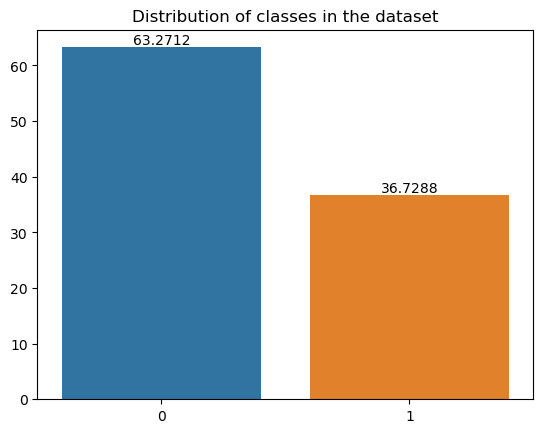

In [11]:
plot_distribution(data.smoking)
# ax = sns.barplot(pd.DataFrame({'0': [calculate_distr(0, data)], '1': [calculate_distr(1, data)]}))
# ax.bar_label(ax.containers[0], label_type='edge')
# ax.set(title='Distribution of classes in the dataset')

- As shown in the above plot, class '1' contains only 36.7 percent of the all dataset. This shows that dataset in imbalanced. Since the minor class (class '1') distribution is between 20-40 percent, then it dataset can be mentioned as 'Mild' imbalanced dataset. Therefore, we should consider this fact that accuracy of the model might not be a good performance evaluation alone. 
    - reference: (https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)

# Data Preprocessing

In [12]:
# Finding columns contain only one type of value
columns_to_drop = ['ID']
for column in data.columns:
    if len(data.loc[:,column].value_counts()) == 1:
        columns_to_drop.append(column)
columns_to_drop

['ID', 'oral']

- Column Oral, contains only value of 'y'. Therefore, we can also exclude this column from the experiment along the ID column
- In the following code block, the mentioned columns will be dropped from the experiment. Also, for ease of coding, all the column names are changed to lowercase.


In [13]:
# dropping the column ID
data = data.drop(labels=columns_to_drop, axis=1)
# lowercasing the column names
data.columns = data.columns.str.lower()
data

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,tartar,smoking
0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,Y,0
1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,Y,0
2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,N,1
3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,Y,0
4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,F,40,170,65,75.0,0.9,0.9,1.0,1.0,110.0,...,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,Y,0
55688,F,45,160,50,70.0,1.2,1.2,1.0,1.0,101.0,...,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,Y,0
55689,F,55,160,50,68.5,1.0,1.2,1.0,1.0,117.0,...,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0,N,0
55690,M,60,165,60,78.0,0.8,1.0,1.0,1.0,133.0,...,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0,N,0


Seprating features columns from target column

In [14]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,tartar
0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,Y
1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,Y
2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,N
3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,Y
4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,F,40,170,65,75.0,0.9,0.9,1.0,1.0,110.0,...,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,Y
55688,F,45,160,50,70.0,1.2,1.2,1.0,1.0,101.0,...,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,Y
55689,F,55,160,50,68.5,1.0,1.2,1.0,1.0,117.0,...,79.0,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0,N
55690,M,60,165,60,78.0,0.8,1.0,1.0,1.0,133.0,...,48.0,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0,N


In [15]:
y

0        0
1        0
2        1
3        0
4        0
        ..
55687    0
55688    0
55689    0
55690    0
55691    1
Name: smoking, Length: 55692, dtype: int64

* All the feature columns are now stored in variable X and the actual target column , which indicates whether the person is smoker or not, is stored in variable y separately.

Encoding categorical variables

In [16]:
old_columns = X.columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, -1])], remainder='passthrough')
X = pd.DataFrame(ct.fit_transform(X))
X

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,1.0,40.0,155.0,60.0,81.3,1.2,1.0,...,82.0,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0.0
1,1.0,0.0,0.0,1.0,40.0,160.0,60.0,81.0,0.8,0.6,...,115.0,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0.0
2,0.0,1.0,1.0,0.0,55.0,170.0,60.0,80.0,0.8,0.8,...,182.0,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0.0
3,0.0,1.0,0.0,1.0,40.0,165.0,70.0,88.0,1.5,1.5,...,254.0,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0.0
4,1.0,0.0,1.0,0.0,40.0,155.0,60.0,86.0,1.0,1.0,...,74.0,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,1.0,0.0,0.0,1.0,40.0,170.0,65.0,75.0,0.9,0.9,...,99.0,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1.0
55688,1.0,0.0,0.0,1.0,45.0,160.0,50.0,70.0,1.2,1.2,...,69.0,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0.0
55689,1.0,0.0,1.0,0.0,55.0,160.0,50.0,68.5,1.0,1.2,...,77.0,79.0,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0.0
55690,0.0,1.0,1.0,0.0,60.0,165.0,60.0,78.0,0.8,1.0,...,79.0,48.0,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0.0


Bringing back the column names and assigning appropriate name for new columns created by encoder

In [17]:
X.columns = old_columns[1:-1].insert(0, ['female', 'male', 'tartar_n', 'tartar_y'])
X

,female,male,tartar_n,tartar_y,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),...,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries
0,1.0,0.0,0.0,1.0,40.0,155.0,60.0,81.3,1.2,1.0,...,82.0,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0.0
1,1.0,0.0,0.0,1.0,40.0,160.0,60.0,81.0,0.8,0.6,...,115.0,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0.0
2,0.0,1.0,1.0,0.0,55.0,170.0,60.0,80.0,0.8,0.8,...,182.0,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0.0
3,0.0,1.0,0.0,1.0,40.0,165.0,70.0,88.0,1.5,1.5,...,254.0,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0.0
4,1.0,0.0,1.0,0.0,40.0,155.0,60.0,86.0,1.0,1.0,...,74.0,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,1.0,0.0,0.0,1.0,40.0,170.0,65.0,75.0,0.9,0.9,...,99.0,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1.0
55688,1.0,0.0,0.0,1.0,45.0,160.0,50.0,70.0,1.2,1.2,...,69.0,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0.0
55689,1.0,0.0,1.0,0.0,55.0,160.0,50.0,68.5,1.0,1.2,...,77.0,79.0,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0.0
55690,0.0,1.0,1.0,0.0,60.0,165.0,60.0,78.0,0.8,1.0,...,79.0,48.0,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0.0


* As mentioned earlier, in data understanding, variables 'gender', and 'tartar' are now encoded.
* We have used one hot encoding to encode these variables. This resulted in creation of new column for each value type in the column. 
* There is another choice of encoding which is called "OrdinalEncoding". However, it is not suitable to be used here. The reason is that there is no numerical order between the values. Therefore, it is not useful in this case.


In [18]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
y

0        0
1        0
2        1
3        0
4        0
        ..
55687    0
55688    0
55689    0
55690    0
55691    1
Length: 55692, dtype: int64

* For the target column, LabelEncoder is used to convert the characters (y/n) to 0 and 1.

Splitting dataset into train set and test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

<AxesSubplot: title={'center': 'Distribution of classes in TRAIN set (Total = 44553)'}>

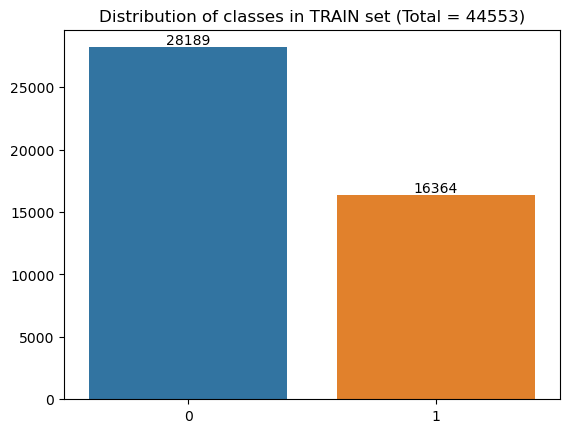

In [20]:
plot_distribution(y_train, title=f"Distribution of classes in TRAIN set (Total = {y_train.value_counts()[0]+y_train.value_counts()[1]})", type='actual')

<AxesSubplot: title={'center': 'Distribution of classes in TEST set (Total = 11139)'}>

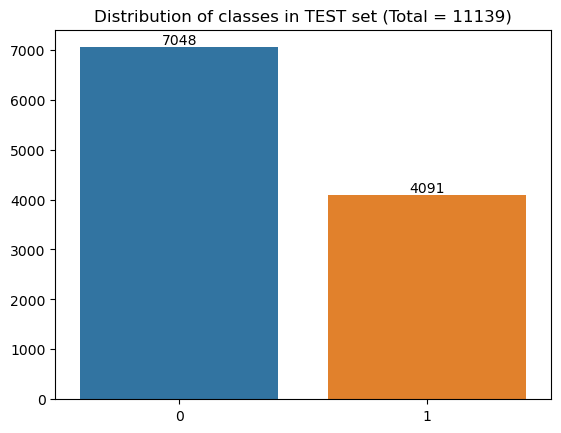

In [21]:
plot_distribution(y_test, title=f"Distribution of classes in TEST set (Total = {y_test.value_counts()[0]+y_test.value_counts()[1]})", type='actual')

* Splitting data has been done by applying following methods:
    - Shuffling: to minimize the chance of getting all same classes in train or test set.
    - Stratify: an important factor to consider when dealing with imbalance dataset. It will make sure the proportion of values in the train set or test set are kept same.
    - random_state: is set to 1 to make the experiment reproducible 
    - finally, there are 20% of data assigned for testing and 80% for training
* The above plots also shows how many data from each class is included for the training and testing. Distribution percentage is same as what we had for the overall dataset. This is because of using stratify

Scaling data

# Training

Getting overview of model performances

Random Forest

In [23]:
make_prediction(estimator=RandomForestClassifier(), train_features=X_train, test_features=X_test, train_label=y_train, test_label=y_test)

Random Forest evaluation on TRAIN SET
{'Accuracy': 1.0, 'Balanced accuracy': 1.0, 'F1 score': 1.0, 'Precision': 1.0, 'Recall': 1.0}
**************************************************
Random Forest evaluation on TEST SET
{'Accuracy': 0.8364305592961666, 'Balanced accuracy': 0.8287472868240713, 'F1 score': 0.7822137222089409, 'Precision': 0.7653801169590644, 'Recall': 0.7998044487900269}


Pipeline(steps=[('scalar', MinMaxScaler()),
                ('estimator', RandomForestClassifier())])

Support Vector Machine

In [24]:
# cls_svc = SVC()
# cls_svc = cls_svc.fit(X_train_sc, y_train)
# cls_svc_predict = cls_svc.predict(X_test_sc)
# cls_svc_evaluation = evaluation_metrics(y_test, cls_svc_predict)

Naive Bays